In [1]:
import random
import numpy as np
import scipy
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import f
from statsmodels.stats.weightstats import *
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import pandas as pd
import docx
%matplotlib inline

In [2]:
class distr:
    def __init__(self, random_state, name, n, *args):
        self.name = name
        self.args = args
        self.n = n
        
        if name == 'norm':
            self.data = stats.norm.rvs(args[0], args[1], size = n, random_state = random_state)
            self.r_mean = args[0]
            self.r_var = args[1]**2
            self.r_std = args[1]
            
        if name == 'chi2':
            self.data = stats.chi2.rvs(args[0], size = n, random_state = random_state)
            self.r_mean = args[0]
            self.r_var = args[0]*2
            self.r_std = np.sqrt(args[0]*2)
            
        if name == 'r':
            self.data = stats.uniform(loc = args[0], scale = args[1] - args[0]).rvs(size = n, random_state = random_state)
            self.r_mean = (args[0] + args[1])/2.
            self.r_var = (args[1] - args[0])**2/12.
            self.r_std = np.sqrt((args[1] - args[0])**2/12.)
            
        self.s_mean = self.data.mean()
        self.s_var = self.data.var()
        self.s_std = self.data.std()
        
        
    def __str__(self):
        return str(self.name) + ' ' + str(self.args) + ' ' + str(self.n) + \
                ' sample_mean=' + str(round(self.s_mean, 2)) + ' sample_var=' + str(round(self.s_var, 2))
    
    def z_test(self, m0):
        z = (self.s_mean - m0)/(self.r_std/np.sqrt(self.n))
        p_val = 2*(1 - stats.norm.cdf(abs(z)))
        return (z, p_val)
    
    def t_test(self, m0):
        z = (self.s_mean - m0)/(self.s_std/np.sqrt(self.n))
        p_val = 2*(1 - stats.t.cdf(abs(z), self.n - 1))
        return (z, p_val)
    
    def chi2_test0(self, v0):
        z = np.sum((self.data - self.r_mean)**2)/v0
        p_val = 2*min(1 - stats.chi2.cdf(z, self.n), stats.chi2.cdf(z, self.n))
        return (z, p_val)
    
    def chi2_test1(self, v0):
        z = self.s_var*(self.n - 1)/v0
        p_val = 2*min(1 - stats.chi2.cdf(z, self.n - 1), stats.chi2.cdf(z, self.n - 1))
        return (z, p_val)

In [3]:
def get_ranks(X):
    array = np.array(X)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return ranks

In [4]:
def task_1(doc, dist_1, dist_2, alpha = 0.05):
    
    doc.tables[0].rows[1].cells[1].text = dist_1.name
    doc.tables[0].rows[2].cells[1].text = dist_2.name
    
    doc.tables[0].rows[1].cells[2].text = str(dist_1.args)
    doc.tables[0].rows[2].cells[2].text = str(dist_2.args)
    
    doc.tables[0].rows[1].cells[3].text = str(dist_1.r_mean)
    doc.tables[0].rows[2].cells[3].text = str(dist_2.r_mean)
    
    doc.tables[0].rows[1].cells[4].text = str(dist_1.r_var)
    doc.tables[0].rows[2].cells[4].text = str(dist_2.r_var)
    
    doc.tables[0].columns[5].cells[1].text = str(dist_1.n)
    
    doc.tables[1].rows[1].cells[1].text = str(round(dist_1.s_mean, 3))
    doc.tables[1].rows[2].cells[1].text = str(round(dist_2.s_mean, 3))
    
    doc.tables[1].rows[1].cells[2].text = str(round(dist_1.s_var, 3))
    doc.tables[1].rows[2].cells[2].text = str(round(dist_2.s_var, 3))
    
    z1 = stats.pearsonr(dist_1.data, dist_2.data)
    z2 = stats.spearmanr(dist_1.data, dist_2.data)
    z3 = stats.kendalltau(dist_1.data, dist_2.data)
    
    doc.tables[1].columns[3].cells[1].text = str(round(z1[0], 3))
    doc.tables[1].columns[4].cells[1].text = str(round(z2[0], 3))
    doc.tables[1].columns[5].cells[1].text = str(round(z3[0], 3))
    
    doc.tables[2].columns[1].cells[1].text = "{:.3e}".format(z1[1])
    doc.tables[2].columns[1].cells[2].text = "{:.3e}".format(z2[1])
    doc.tables[2].columns[1].cells[3].text = "{:.3e}".format(z3[1])
    
    p_arr = [z1[1], z2[1], z3[1]]
    
    for val in enumerate(p_arr):
        
        if val[1] < alpha:
            doc.tables[2].rows[val[0] + 1].cells[2].text = 'H0 отверг'
            doc.tables[2].rows[val[0] + 1].cells[3].text = 'Ош. 1го рода'
        else:
            doc.tables[2].rows[val[0] + 1].cells[2].text = 'H0 приним'
            doc.tables[2].rows[val[0] + 1].cells[3].text = 'Нет'
            
    plt.scatter(dist_1.data, dist_2.data)
    plt.savefig('lab4_im/lab4_1.png')

In [5]:
def task_2(doc, dist_1, dist_2, alpha = 0.05):
    
    h = plt.hist2d(dist_1.data, dist_2.data, bins = 5)
    
    for i in range(5):
        doc.tables[3].rows[i+1].cells[0].text = '['+str(round(h[1][i], 2))+';'+str(round(h[1][i+1], 2)) + ')'
        doc.tables[3].columns[i+1].cells[0].text = '['+str(round(h[2][i], 2))+';'+str(round(h[2][i+1], 2)) + ')'
    
    z = stats.chi2_contingency(h[0])
    
    for i in range(5):
        for j in range(5):
            doc.tables[3].rows[i+1].cells[j+1].text = str(h[0][i][j]) + '|' + str(round(z[3][i][j], 2))
    
    doc.tables[4].rows[1].cells[0].text = str(round(z[0], 3))
    doc.tables[4].rows[1].cells[1].text = "{:.3e}".format(z[1])
    
    if z[1] < alpha:
        doc.tables[4].rows[1].cells[2].text = 'H0 отверг'
        doc.tables[4].rows[1].cells[3].text = 'Ош. 1го рода'
    else:
        doc.tables[4].rows[1].cells[2].text = 'H0 приним'
        doc.tables[4].rows[1].cells[3].text = 'Нет'

In [6]:
def graphics(dist_1, dist_2):
    
    lamb_s = np.linspace(0., 1., 100)
    u = []
    v = []
    for lamb in lamb_s:
        u.append(lamb*dist_1.data + (1-lamb)*dist_2.data)
        v.append(lamb*dist_1.data**3 + (1-lamb)*dist_2.data**3)
    
    pears_corr = []
    spear_corr = []
    kend_corr = []
    for x_i in u:
        pears_corr.append(stats.pearsonr(dist_1.data, x_i)[0])
        spear_corr.append(stats.spearmanr(dist_1.data, x_i)[0])
        kend_corr.append(stats.kendalltau(dist_1.data, x_i)[0])
        
    fig, ax = plt.subplots(2, 1)
    fig.set_size_inches(10.5, 10.5)
    ax[0].plot(lamb_s, pears_corr, label = 'pears', linestyle=':')
    ax[0].plot(lamb_s, spear_corr, label = 'spear', linestyle='-.')
    ax[0].plot(lamb_s, kend_corr, label = 'kend')
    ax[0].legend()
    
    
    pears_corr = []
    spear_corr = []
    kend_corr = []
    for x_i in v:
        pears_corr.append(stats.pearsonr(dist_1.data, x_i)[0])
        spear_corr.append(stats.spearmanr(dist_1.data, x_i)[0])
        kend_corr.append(stats.kendalltau(dist_1.data, x_i)[0])
        
    ax[1].plot(lamb_s, pears_corr, label = 'pears', linestyle=':')
    ax[1].plot(lamb_s, spear_corr, label = 'spear', linestyle='-.')
    ax[1].plot(lamb_s, kend_corr, label = 'kend')
    ax[1].legend()
    
    plt.savefig('lab4_im/lab4_2.png')
    
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(15.5, 10.5)
    ax[0][0].scatter(dist_1.data, dist_2.data**3)
    ax[1][0].scatter(dist_1.data, dist_1.data**3)
    ax[0][1].scatter(get_ranks(dist_1.data), get_ranks(dist_2.data**3))
    ax[1][1].scatter(get_ranks(dist_1.data), get_ranks(dist_1.data**3))
    plt.savefig('lab4_im/lab4_3.png')

In [7]:
doc = docx.Document('ms_otchet4.docx')
d_1 = distr(513, 'r', 100, 2, 6)
d_2 = distr(536, 'r', 100, 2, 6)
print(d_1, d_2, sep = '\n')

r (2, 6) 100 sample_mean=4.15 sample_var=1.2
r (2, 6) 100 sample_mean=3.82 sample_var=1.23


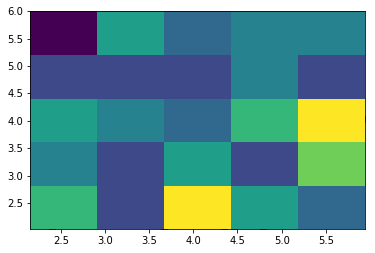

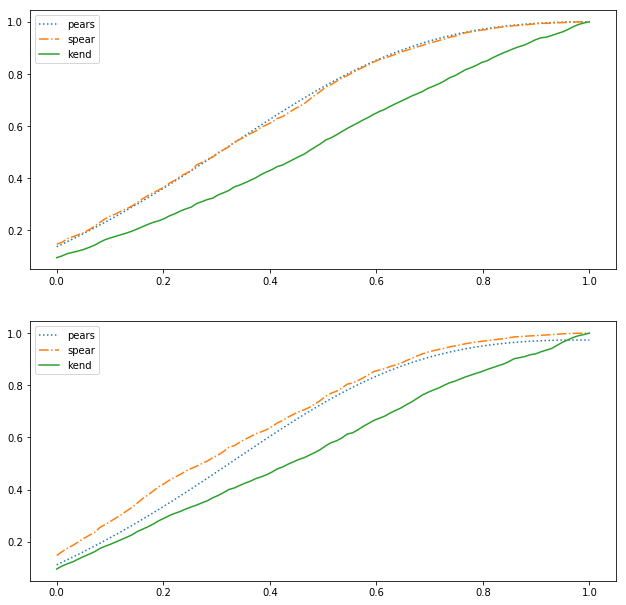

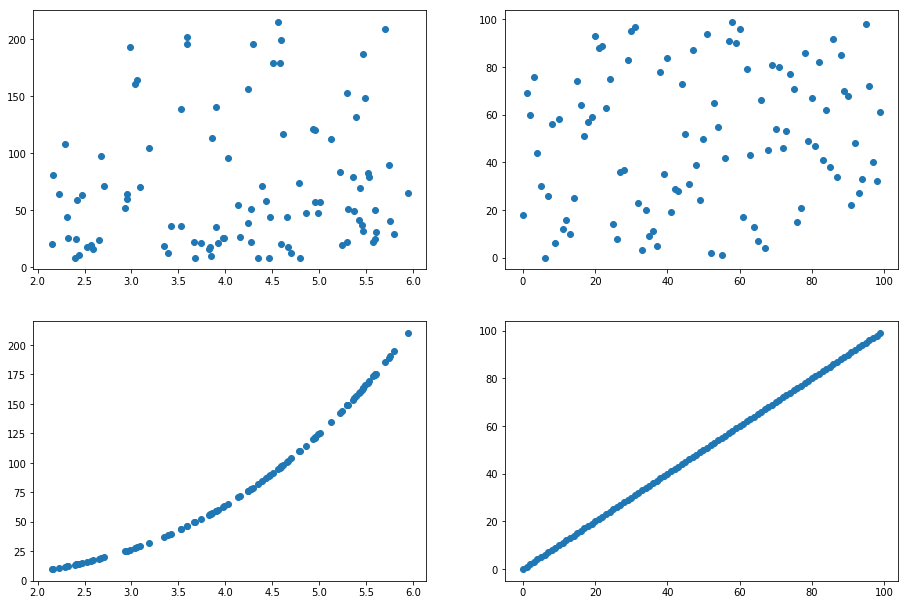

In [8]:
task_1(doc, d_1, d_2)
task_2(doc, d_1, d_2)
graphics(d_1, d_2)

In [9]:
doc.save('lab4_nik.docx')